In [46]:
import numpy as np

import PySpice
from PySpice.Doc.ExampleTools import find_libraries
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

from spice_net import *
from helpers import *

from os import system
import networkx as nx
import ltspice
from time import time
import matplotlib.pyplot as plt
import itertools
import tqdm
import math

In [5]:
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-subprocess' 

#### Benchmarks to motivate switching to PySpice's NGSPICE interface over LTSPICE command line interface

In [6]:
def sim_ltspice(n):
    circuit = Circuit('test')

    circuit.V(1, 1, 0, f'{{V1}}')
    circuit.R(1, 2, 1, 5)
    circuit.R(2, 2, 0, 1)


    xs = np.random.randn(n)
    ys = np.empty(n)

    for i, x in enumerate(xs):
        circuit.parameter('V1', x)
        # simulator = circuit.simulator()
        # analysis = simulator.operating_point()
        # ys[i] = analysis['2'][0]

        netlist = str(circuit)

        with open(f'{circuit.title}.cir', 'wt') as f:
            f.write(netlist + '.op\n')

        system(f'/Applications/LTspice.app/Contents/MacOS/LTspice -b {circuit.title}.cir')
        
        l = ltspice.Ltspice(f'{circuit.title}.raw')
        l.parse()
        ys[i] = l.get_data('V(2)')[0]

    return ys

def sim_loop(n):
    circuit = Circuit('test')

    circuit.V(1, 1, 0)
    circuit.R(1, 2, 1, 5)
    circuit.R(2, 2, 0, 1)

    xs = np.random.randn(n)
    ys = np.empty(n)

    for i, x in enumerate(xs):
        circuit.V1.dc_value = x
        simulator = circuit.simulator(spice_command='ngspice')
        analysis = simulator.operating_point()
        ys[i] = analysis['2'][0]

    return ys

def sim_sweep(n):
    circuit = Circuit('test')

    circuit.V('dummy', 'dummy', 0, -1)
    
    circuit.R(1, 2, 1, 5)
    circuit.R(2, 2, 0, 1)

    xs = np.random.randn(n)
    arr = [str(val) for pair in zip(range(1, len(xs)+1), xs) for val in pair]
    ss = ', '.join(arr)
    s = f'pwl(V(dummy), {ss})' if n > 1 else xs[0]
    circuit.B(1, 1, 0, v=s)

    simulator = circuit.simulator(ngspice_command='ngspice')
    analysis = simulator.dc(Vdummy=slice(1, n, 1))

    return analysis['2']

def sim_xyce(n):
    circuit = Circuit('test')

    circuit.V('dummy', 'dummy', 0, -1)
    
    circuit.R(1, 2, 1, 5)
    circuit.R(2, 2, 0, 1)

    xs = np.random.randn(n)
    arr = [str(val) for pair in zip(range(1, len(xs)+1), xs) for val in pair]
    ss = ', '.join(arr)
    s = f'{{TABLE(V(dummy), {ss})}}' if n > 1 else xs[0]
    circuit.B(1, 1, 0, v=s)

    simulator = circuit.simulator(xyce_command='/Users/lancemathias/Projects/Xyce_build/src/Xyce')
    analysis = simulator.dc(Vdummy=slice(1, n, 1))

    return analysis['2']

##### Time benchmarks
Clearly, the NGSpice implementations are much faster (since they don't have to write to a file). It's much faster still to treat multiple evaluations on a single (fixed) circuit as parameter (voltage) sweeps over time and extract the results as such

In [16]:
%timeit sim_ltspice(100)

FileNotFoundError: [Errno 2] No such file or directory: 'Xyce'

In [7]:
%timeit sim_loop(100)

671 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit sim_sweep(100)

7.35 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit sim_xyce(100)


Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal

Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device T

18 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that all 3 methods are equivalent and yield correct results

In [10]:
np.random.seed(0)
sim_ltspice(100)

array([ 0.29400873,  0.06669287,  0.163123  ,  0.3734822 ,  0.31125966,
       -0.16287965,  0.15834807, -0.0252262 , -0.01720314,  0.06843308,
        0.02400726,  0.24237892,  0.12683962,  0.02027917,  0.0739772 ,
        0.05561239,  0.24901319, -0.03419304,  0.05217795, -0.14234929,
       -0.42549831,  0.10893643,  0.1440727 , -0.12369417,  0.37829244,
       -0.24239428,  0.00762642, -0.03119731,  0.25546321,  0.24489313,
        0.02582457,  0.06302708, -0.14796428, -0.33013275, -0.05798536,
        0.02605816,  0.20504844,  0.20039664, -0.06455447, -0.05038379,
       -0.17475882, -0.23666966, -0.28437838,  0.32512924, -0.08494203,
       -0.07301238, -0.20879923,  0.12958172, -0.26898298, -0.03545671,
       -0.14924443,  0.06448375, -0.08513419, -0.19677202, -0.00469704,
        0.07138865,  0.0110862 ,  0.05041198, -0.10572035, -0.06045686,
       -0.11207674, -0.05992553, -0.13552438, -0.28771377,  0.02957102,
       -0.06696349, -0.27169973,  0.07713038, -0.15121639,  0.00

In [11]:
np.random.seed(0)
sim_loop(100)

array([ 0.29400872,  0.06669287,  0.163123  ,  0.3734822 ,  0.31125967,
       -0.16287965,  0.15834807, -0.0252262 , -0.01720314,  0.06843308,
        0.02400726,  0.24237892,  0.12683962,  0.02027917,  0.07397721,
        0.05561239,  0.24901318, -0.03419304,  0.05217795, -0.14234929,
       -0.4254983 ,  0.10893643,  0.1440727 , -0.12369417,  0.37829244,
       -0.24239428,  0.00762642, -0.03119731,  0.2554632 ,  0.24489313,
        0.02582457,  0.06302709, -0.14796429, -0.33013274, -0.05798536,
        0.02605816,  0.20504845,  0.20039664, -0.06455447, -0.05038379,
       -0.17475883, -0.23666966, -0.28437837,  0.32512923, -0.08494203,
       -0.07301238, -0.20879923,  0.12958173, -0.26898297, -0.03545671,
       -0.14924443,  0.06448375, -0.08513419, -0.19677203, -0.00469704,
        0.07138865,  0.0110862 ,  0.05041198, -0.10572035, -0.06045686,
       -0.11207674, -0.05992553, -0.13552438, -0.28771377,  0.02957102,
       -0.06696349, -0.27169972,  0.07713038, -0.15121639,  0.00

In [12]:
np.random.seed(0)
sim_sweep(100)

WaveForm 2 [ 0.29400872  0.06669287  0.163123    0.3734822   0.31125967 -0.16287965
  0.15834807 -0.0252262  -0.01720314  0.06843308  0.02400726  0.24237892
  0.12683962  0.02027917  0.07397721  0.05561239  0.24901318 -0.03419304
  0.05217795 -0.14234929 -0.4254983   0.10893643  0.1440727  -0.12369417
  0.37829244 -0.24239428  0.00762642 -0.03119731  0.2554632   0.24489313
  0.02582457  0.06302709 -0.14796429 -0.33013274 -0.05798536  0.02605816
  0.20504845  0.20039664 -0.06455447 -0.05038379 -0.17475883 -0.23666966
 -0.28437837  0.32512923 -0.08494203 -0.07301238 -0.20879923  0.12958173
 -0.26898297 -0.03545671 -0.14924443  0.06448375 -0.08513419 -0.19677203
 -0.00469704  0.07138865  0.0110862   0.05041198 -0.10572035 -0.06045686
 -0.11207674 -0.05992553 -0.13552438 -0.28771377  0.02957102 -0.06696349
 -0.27169972  0.07713038 -0.15121639  0.00865757  0.12151509  0.02149715
  0.18990011 -0.2058043   0.06705694 -0.11413502 -0.14513286 -0.09647494
 -0.05192542  0.00936089 -0.19419164  0.

In [29]:
np.random.seed(0)
sim_xyce(100)


Netlist warning: No print specified

Netlist warning: Voltage Node (DUMMY) connected to only 1 device Terminal


WaveForm 2 [ 0.29400872  0.06669287  0.163123    0.3734822   0.31125967 -0.16287965
  0.15834807 -0.0252262  -0.01720314  0.06843308  0.02400726  0.24237892
  0.12683962  0.02027917  0.07397721  0.05561239  0.24901318 -0.03419304
  0.05217795 -0.14234929 -0.4254983   0.10893643  0.1440727  -0.12369417
  0.37829244 -0.24239428  0.00762642 -0.03119731  0.2554632   0.24489313
  0.02582457  0.06302709 -0.14796429 -0.33013274 -0.05798536  0.02605816
  0.20504845  0.20039664 -0.06455447 -0.05038379 -0.17475883 -0.23666966
 -0.28437837  0.32512923 -0.08494203 -0.07301238 -0.20879923  0.12958173
 -0.26898297 -0.03545671 -0.14924443  0.06448375 -0.08513419 -0.19677203
 -0.00469704  0.07138865  0.0110862   0.05041198 -0.10572035 -0.06045686
 -0.11207674 -0.05992553 -0.13552438 -0.28771377  0.02957102 -0.06696349
 -0.27169972  0.07713038 -0.15121639  0.00865757  0.12151509  0.02149715
  0.18990011 -0.2058043   0.06705694 -0.11413502 -0.14513286 -0.09647494
 -0.05192542  0.00936089 -0.19419164  0.

#### Benchmarks to determine SPICE engine's best-case performance

In [8]:
def build_net(n, p, in_nodes, out_nodes):
    con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)
    while not nx.is_connected(con_graph):
        con_graph = nx.erdos_renyi_graph(n=n, p=p, directed=False)
    # con_graph = nx.grid_graph(dim=[n, n], periodic=True)
    # mapping = {k:i+1 for i, k in enumerate(con_graph.nodes)}
    # con_graph = nx.relabel_nodes(con_graph, mapping)

    for u, v in con_graph.edges():
        # con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = np.random.normal(1, 1)


    n_nodes = con_graph.number_of_nodes()
    node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(n_nodes-in_nodes-out_nodes-1))
    node_cfg = np.random.choice(n_nodes, size=(in_nodes + out_nodes, 2), replace=False)
    node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

    net = TransistorNetwork('speed_test', con_graph, node_cfg)
    net.include('bjt.lib')

    return net

In [7]:
n_sweep = [4, 10, 20, 50]
t_sweep = [100, 500, 1000, 2000]
in_nodes = 2
out_nodes = 1

n_runs = 3 # number of times to repeat each run. time will be averaged across runs

build_times = {}
run_times = {}

In [4]:
for n, t in tqdm.tqdm(itertools.product(n_sweep, t_sweep)):
    if n not in build_times:
        build_times[n] = {}

    if n not in run_times:
        run_times[n] = {}

    bt = []
    rt = []
    for _ in range(n_runs):
        inputs = np.random.randn(t, in_nodes)

        start = time()
        net = build_net(n, 0, in_nodes, out_nodes)
        end = time()
        bt.append(end - start)

        start = time()
        out = net.solve(inputs)
        end = time()
        rt.append(end - start)

    build_times[n] = np.mean(bt)
    run_times[n][t] = np.mean(rt)

0it [00:00, ?it/s]Note: can't find the initialization file spinit.
Unsupported Ngspice version 38
16it [58:24, 219.02s/it]


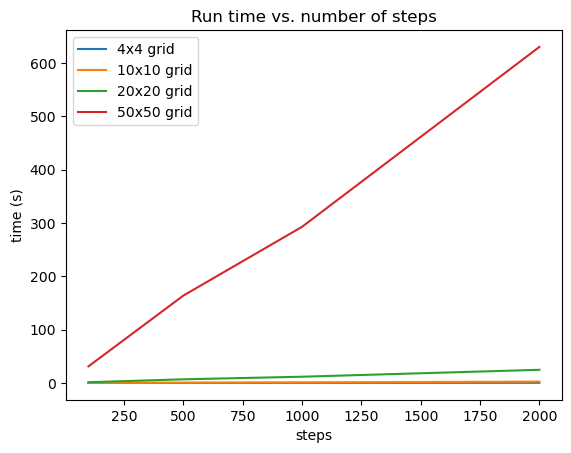

In [5]:
for n in n_sweep:
    plt.plot(t_sweep, [run_times[n][t] for t in t_sweep], label=f'{n}x{n} grid')
plt.xlabel('steps')
plt.ylabel('time (s)')
plt.title('Run time vs. number of steps')
plt.legend();

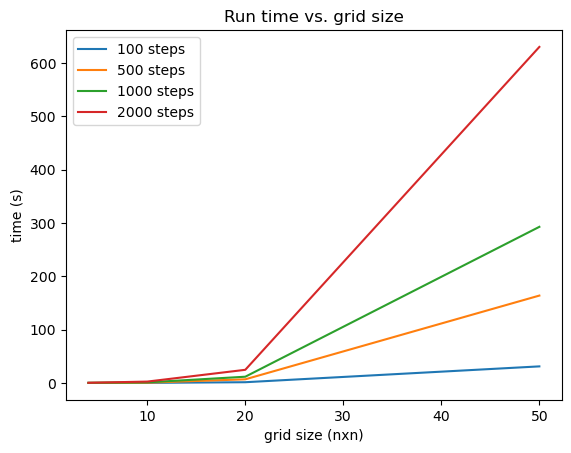

In [6]:
for t in t_sweep:
    plt.plot(n_sweep, [run_times[n][t] for n in n_sweep], label=f'{t} steps')
plt.xlabel('grid size (nxn)')
plt.ylabel('time (s)')
plt.title('Run time vs. grid size')
plt.legend();

##### Constant number of nodes, varying number of edges

In [33]:
n = 50
t = 500
p_sweep = [0.2, 0.4, 0.6, 0.8, 1.]

in_nodes = 2
out_nodes = 1

n_runs = 3 # number of times to repeat each run. time will be averaged across runs

build_times = {}
run_times = {}

In [34]:
for p in tqdm.tqdm(p_sweep):

    bt = []
    rt = []
    for _ in range(n_runs):
        inputs = np.random.randn(t, in_nodes)

        start = time()
        net = build_net(n, p, in_nodes, out_nodes)
        end = time()
        bt.append(end - start)

        start = time()
        out = net.solve(inputs)
        end = time()
        rt.append(end - start)

    build_times[p] = np.mean(bt)
    run_times[p] = np.mean(rt)

100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


In [40]:
np.stack((np.array(p_sweep)*math.comb(n, 2), np.ones(len(p_sweep)))).shape

(2, 5)

In [44]:
np.array(list(run_times.values())).shape

(5,)

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_54829/2923239857.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b) = np.linalg.lstsq(np.stack((np.array(p_sweep)*math.comb(n, 2), np.ones(len(p_sweep)))).T, np.array(list(run_times.values())))[0]


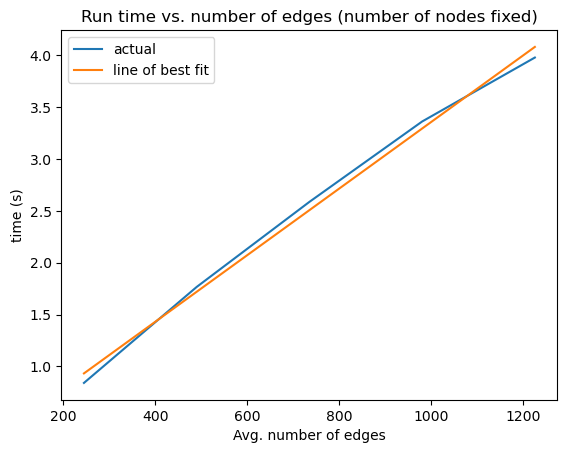

In [51]:
plt.plot(np.array(p_sweep)*math.comb(n, 2), run_times.values(), label='actual')

(a, b) = np.linalg.lstsq(np.stack((np.array(p_sweep)*math.comb(n, 2), np.ones(len(p_sweep)))).T, np.array(list(run_times.values())))[0]

plt.plot(np.array(p_sweep)*math.comb(n, 2), np.array(p_sweep)*math.comb(n, 2)*a + b, label='line of best fit')

plt.xlabel('Avg. number of edges')
plt.ylabel('time (s)')
plt.legend()
plt.title('Run time vs. number of edges (number of nodes fixed)');

##### Constant number of edges, varying number of nodes

In [29]:
n_sweep = [20, 30, 40, 50, 60, 70]
t = 500
# p_base = 0.6
n_edges = 200

in_nodes = 2
out_nodes = 1

n_runs = 3 # number of times to repeat each run. time will be averaged across runs

build_times = {}
run_times = {}

In [30]:
for n in tqdm.tqdm(n_sweep):

    bt = []
    rt = []
    for _ in range(n_runs):
        inputs = np.random.randn(t, in_nodes)

        start = time()

        p = n_edges / math.comb(n, 2)
        net = build_net(n, p, in_nodes, out_nodes)
        end = time()
        bt.append(end - start)

        start = time()
        out = net.solve(inputs)
        end = time()
        rt.append(end - start)

    build_times[p] = np.mean(bt)
    run_times[p] = np.mean(rt)

100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


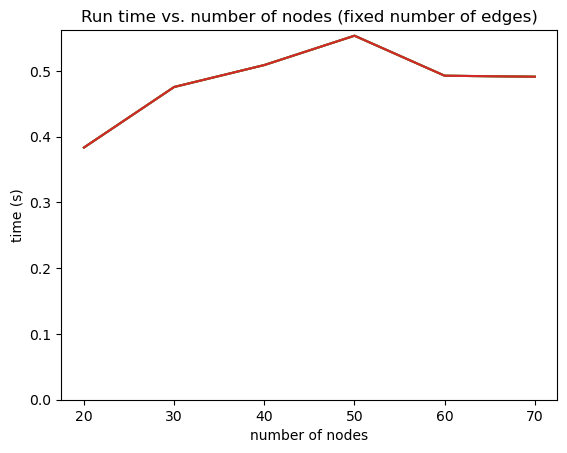

In [31]:
for t in t_sweep:
    plt.plot(n_sweep, run_times.values())
plt.xlabel('number of nodes')
plt.ylabel('time (s)')
plt.ylim(bottom=0)
plt.title('Run time vs. number of nodes (fixed number of edges)');

## Benchmarks on 4x4 transistor grid

In [63]:
np.random.seed(0)

grid_graph = nx.grid_graph([4, 4], periodic=True)

for e in grid_graph.edges:
    # grid_graph[e[0]][e[1]]['weight'] = np.random.uniform(0, 5)    # random init
    grid_graph[e[0]][e[1]]['weight'] = 5                            # init to max value

transistor = TransistorNetwork('benchmarking_net', con_graph=grid_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)

In [92]:
dset = np.random.uniform(0, 1, size=(100, 2))

In [65]:
# benchmark transistor network on sweep of 1 input at a time
%timeit transistor.solve(dset[:1, :1])

11.7 ms ± 67.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
# benchmark transistor network on sweep of 100 inputs at a time
%timeit transistor.solve(dset[:, :1])

19 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Training loop code:
```python
free_analysis = net._solve(x)
free = np.array([u_V(free_analysis.nodes[str(i)]) for i in net.__nodes__])

preds = np.zeros((len(net.outputs), 1))

for k, v in enumerate(net.outputs):
    a, b = v.node_names
    preds[k] = u_V(free_analysis.nodes[a] - free_analysis.nodes[b])
nudges = eta * y + (1-eta) * preds

clamped = net.solve(x, nudges.reshape(y.shape))

free_rep = np.tile(free, [n_nodes, 1])
clamped_rep = np.tile(clamped, [n_nodes,1])

delta_free = free_rep - free_rep.T
delta_clamped = clamped_rep - clamped_rep.T

update = -gamma * (delta_clamped**2 - delta_free**2)

trainable_updates = update[e1, e2]

net.update(trainable_updates) 

# logging, etc...
```

In [67]:
# time first solve
%timeit free_analysis = transistor.solve(dset[:1, :1])

11.9 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
# time nudge computation
free_analysis = transistor._solve(dset[:1, :1])

def compute_nudges(net, y, free_analysis):
    eta = 0.5
    free = np.array([u_V(free_analysis.nodes[str(i)]) for i in net.__nodes__])

    preds = np.zeros((len(net.outputs), 1))

    for k, v in enumerate(net.outputs):
        a, b = v.node_names
        preds[k] = u_V(free_analysis.nodes[a] - free_analysis.nodes[b])
    nudges = eta * y + (1-eta) * preds

%timeit compute_nudges(transistor, dset[:1, :1], free_analysis)

45 µs ± 576 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
# time clamped computation
eta = 0.5
free = np.array([u_V(free_analysis.nodes[str(i)]) for i in transistor.__nodes__])

preds = np.zeros((len(transistor.outputs), 1))

for k, v in enumerate(transistor.outputs):
    a, b = v.node_names
    preds[k] = u_V(free_analysis.nodes[a] - free_analysis.nodes[b])
nudges = eta * dset[:1, :1] + (1-eta) * preds

x, y = dset[:1, :1], dset[:1, :1]

%timeit clamped = transistor.solve(x, nudges.reshape(y.shape))


11.8 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
# time update computation
def compute_updates(free, clamped, n_nodes, e1, e2, gamma):
    free_rep = np.tile(free, [n_nodes, 1])
    clamped_rep = np.tile(clamped, [n_nodes,1])

    delta_free = free_rep - free_rep.T
    delta_clamped = clamped_rep - clamped_rep.T

    update = -gamma * (delta_clamped**2 - delta_free**2)

    trainable_updates = update[e1, e2]

e1 = []
e2 = []
for E in transistor.edges:
        a, b = list(map(int, E.circ.node_names[:2]))
        e1.append(a)
        e2.append(b)

clamped = transistor.solve(x, nudges.reshape(y.shape))

%timeit compute_updates(free, clamped, len(transistor.__nodes__), e1, e2, 0.1)

224 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [71]:
# time update application
n_nodes = len(transistor.__nodes__)
gamma = 0.1

free_rep = np.tile(free, [n_nodes, 1])
clamped_rep = np.tile(clamped, [n_nodes,1])

delta_free = free_rep - free_rep.T
delta_clamped = clamped_rep - clamped_rep.T

update = -gamma * (delta_clamped**2 - delta_free**2)

trainable_updates = update[e1, e2]

%timeit transistor.update(trainable_updates)

42.1 µs ± 562 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [101]:
# time training over 5 samples for 20 epochs (no logging)
transistor = TransistorNetwork('benchmarking_net', con_graph=grid_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)

%timeit train(transistor, dset[:5, :1], dset[:5, 1:2], epochs=20, gamma=gamma, eta=eta, log_steps=99999999)

Epoch 1: 0.029999188054699154
Epoch 1: 0.02453645123966965
Epoch 1: 0.020359696845096878
Epoch 1: 0.017153330596636842
Epoch 1: 0.01466901116497668
Epoch 1: 0.0127323911733008
Epoch 1: 0.011186827536294153


In [ ]:
# time training over 5 samples for 20 epochs (with logging)
transistor = TransistorNetwork('benchmarking_net', con_graph=grid_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)

%timeit train(transistor, dset[:5, :1], dset[:5, 1:2], epochs=20, gamma=gamma, eta=eta, log_steps=1)

Epoch 1: 0.15067464947703452
Epoch 2: 0.14968218172028613
Epoch 3: 0.14869820750488458
Epoch 4: 0.14772208585982397
Epoch 5: 0.14674729877510476
Epoch 1: 0.14579232649667723
Epoch 2: 0.1448412495261064
Epoch 3: 0.14389996392100624
Epoch 4: 0.14296003600011217
Epoch 5: 0.14201944654502743
Epoch 1: 0.14110583571775093
Epoch 2: 0.14014701555360326
Epoch 3: 0.13923873916295787
Epoch 4: 0.1383045533033128
Epoch 5: 0.13737955160127774
Epoch 1: 0.13645910143677747
Epoch 2: 0.1355322130833879
Epoch 3: 0.13459818821062797
Epoch 4: 0.13366837874210924
Epoch 5: 0.13272899134966898
Epoch 1: 0.13176562317124169
Epoch 2: 0.13082968700318315
Epoch 3: 0.12986020840373144
Epoch 4: 0.1288841569505791
Epoch 5: 0.1279230195231635
Epoch 1: 0.12695124296447874
Epoch 2: 0.125953528544746
Epoch 3: 0.12495984243200679
Epoch 4: 0.12394865672944788
Epoch 5: 0.12295352001948778
Epoch 1: 0.1219112008426791
Epoch 2: 0.12091416865637665
Epoch 3: 0.11984417009703834
Epoch 4: 0.11878571611626718
Epoch 5: 0.11811998028